# Task 3: Basic Multi-label Classification Approach (Improved)

This notebook implements an improved version of the SVM classifier with better class balancing and feature extraction.

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from collections import Counter

## Data Loading and Basic Preprocessing

In [6]:
def basic_preprocess(text):
    """Minimal text preprocessing to preserve information"""
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep URLs and hashtags
    text = re.sub(r'[^\w\s#@/:.]+', '', text)
    
    return text.strip()

# Load data
print("Loading data...")
df = pd.read_csv("scitweets_export.tsv", sep="\t")

# Basic preprocessing
print("Preprocessing text...")
df['processed_text'] = df['text'].apply(basic_preprocess)

# Prepare labels
label_cols = ["scientific_claim", "scientific_reference", "scientific_context"]
Y = df[label_cols].fillna(0).astype(int)

# Calculate class weights for each label
class_weights = []
for col in Y.columns:
    counts = Counter(Y[col])
    # More aggressive weight balancing
    weight = {0: 1.0, 1: counts[0] / counts[1] * 1.5}  # Increase minority class weight
    class_weights.append(weight)

# Display dataset stats
print("\nLabel distribution and weights:")
for col, weights in zip(label_cols, class_weights):
    counts = Y[col].value_counts()
    print(f"\n{col}:")
    print(f"Class 0: {counts[0]} ({counts[0]/len(Y)*100:.1f}%)")
    print(f"Class 1: {counts[1]} ({counts[1]/len(Y)*100:.1f}%)")
    print(f"Weights: {weights}")

# Create stratification column for multi-label data
strat_col = Y.apply(lambda x: ''.join(x.astype(str)), axis=1)

Loading data...
Preprocessing text...

Label distribution and weights:

scientific_claim:
Class 0: 877 (76.9%)
Class 1: 263 (23.1%)
Weights: {0: 1.0, 1: 5.001901140684411}

scientific_reference:
Class 0: 937 (82.2%)
Class 1: 203 (17.8%)
Weights: {0: 1.0, 1: 6.9236453201970445}

scientific_context:
Class 0: 889 (78.0%)
Class 1: 251 (22.0%)
Weights: {0: 1.0, 1: 5.312749003984064}


## K-Fold Cross-Validation with Improved Pipeline

In [7]:
def evaluate_kfold(X, Y, strat_col, class_weights, n_splits=5):
    """Perform k-fold cross-validation with improved pipeline"""
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        'accuracy': [],
        'precision_micro': [],
        'recall_micro': [],
        'f1_micro': [],
        'precision_macro': [],
        'recall_macro': [],
        'f1_macro': []
    }
    
    # For plotting
    fold_metrics_history = []
    
    # Create improved TF-IDF vectorizer
    print("Vectorizing text...")
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),     # Unigrams, bigrams, and trigrams
        min_df=3,               # Remove very rare words
        max_df=0.95,            # Remove very common words
        strip_accents='unicode', # Handle French accents
        sublinear_tf=True,      # Apply sublinear scaling
        use_idf=True,           # Use inverse document frequency
        lowercase=True
    )
    X_tfidf = vectorizer.fit_transform(X)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tfidf, strat_col), 1):
        print(f"\nProcessing fold {fold}/{n_splits}...")
        
        # Split data
        X_train = X_tfidf[train_idx]
        X_val = X_tfidf[val_idx]
        Y_train = Y.iloc[train_idx]
        Y_val = Y.iloc[val_idx]
        
        # Create a single base classifier
        base_svc = LinearSVC(
            random_state=42,
            max_iter=2000,
            dual=False,
            C=1.0
        )
        
        # Add probability calibration
        clf = CalibratedClassifierCV(base_svc, cv=3)
        
        # Create multi-output classifier with the single base classifier
        multi_clf = MultiOutputClassifier(clf, n_jobs=-1)
        
        # Train model
        multi_clf.fit(X_train, Y_train)
        
        # Predict
        Y_pred = multi_clf.predict(X_val)
        
        # Calculate metrics
        fold_metrics = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision_micro': precision_score(Y_val, Y_pred, average='micro'),
            'recall_micro': recall_score(Y_val, Y_pred, average='micro'),
            'f1_micro': f1_score(Y_val, Y_pred, average='micro'),
            'precision_macro': precision_score(Y_val, Y_pred, average='macro'),
            'recall_macro': recall_score(Y_val, Y_pred, average='macro'),
            'f1_macro': f1_score(Y_val, Y_pred, average='macro')
        }
        
        # Store metrics
        for metric, value in fold_metrics.items():
            metrics[metric].append(value)
        fold_metrics_history.append(fold_metrics)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"F1 (micro): {fold_metrics['f1_micro']:.4f}")
        print(f"F1 (macro): {fold_metrics['f1_macro']:.4f}")
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(Y_val, Y_pred, target_names=label_cols))
        
        # Print label distribution
        print("\nPredicted label distribution in this fold:")
        for i, col in enumerate(Y_train.columns):
            val_dist = np.bincount(Y_pred[:, i]) / len(Y_pred)
            print(f"\n{col}:")
            print(f"Distribution: {dict(enumerate(val_dist))}")
    
    # Print overall results
    print("\n=== Overall Results ===")
    for metric, scores in metrics.items():
        mean = np.mean(scores)
        std = np.std(scores)
        print(f"{metric}: {mean:.4f} ± {std:.4f}")
    
    # Plot metrics
    plt.figure(figsize=(15, 5))
    metrics_df = pd.DataFrame(fold_metrics_history)
    
    for i, metric in enumerate(['accuracy', 'f1_micro', 'f1_macro']):
        plt.subplot(1, 3, i+1)
        plt.plot(range(1, n_splits + 1), metrics_df[metric], marker='o')
        plt.title(f'{metric.capitalize()} across Folds')
        plt.xlabel('Fold')
        plt.ylabel('Score')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metrics, metrics_df, vectorizer, multi_clf

## Training and Evaluation

=== Starting K-Fold Cross-Validation ===
Vectorizing text...

Processing fold 1/5...

Fold 1 Results:
Accuracy: 0.7149
F1 (micro): 0.5641
F1 (macro): 0.5606

Classification Report:
                      precision    recall  f1-score   support

    scientific_claim       0.80      0.45      0.58        53
scientific_reference       0.68      0.41      0.52        41
  scientific_context       0.71      0.50      0.59        50

           micro avg       0.73      0.46      0.56       144
           macro avg       0.73      0.46      0.56       144
        weighted avg       0.74      0.46      0.56       144
         samples avg       0.16      0.14      0.15       144


Predicted label distribution in this fold:

scientific_claim:
Distribution: {0: np.float64(0.868421052631579), 1: np.float64(0.13157894736842105)}

scientific_reference:
Distribution: {0: np.float64(0.8903508771929824), 1: np.float64(0.10964912280701754)}

scientific_context:
Distribution: {0: np.float64(0.84649122807

/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavio


Fold 2 Results:
Accuracy: 0.7149
F1 (micro): 0.5217
F1 (macro): 0.5142

Classification Report:
                      precision    recall  f1-score   support

    scientific_claim       0.83      0.36      0.50        53
scientific_reference       1.00      0.29      0.45        41
  scientific_context       0.82      0.46      0.59        50

           micro avg       0.86      0.38      0.52       144
           macro avg       0.88      0.37      0.51       144
        weighted avg       0.87      0.38      0.52       144
         samples avg       0.14      0.11      0.12       144


Predicted label distribution in this fold:

scientific_claim:
Distribution: {0: np.float64(0.8991228070175439), 1: np.float64(0.10087719298245613)}

scientific_reference:
Distribution: {0: np.float64(0.9473684210526315), 1: np.float64(0.05263157894736842)}

scientific_context:
Distribution: {0: np.float64(0.8771929824561403), 1: np.float64(0.12280701754385964)}

Processing fold 3/5...


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavio


Fold 3 Results:
Accuracy: 0.7281
F1 (micro): 0.6094
F1 (macro): 0.5912

Classification Report:
                      precision    recall  f1-score   support

    scientific_claim       0.85      0.53      0.65        53
scientific_reference       0.72      0.33      0.45        40
  scientific_context       0.77      0.60      0.67        50

           micro avg       0.79      0.50      0.61       143
           macro avg       0.78      0.48      0.59       143
        weighted avg       0.79      0.50      0.60       143
         samples avg       0.19      0.15      0.16       143


Predicted label distribution in this fold:

scientific_claim:
Distribution: {0: np.float64(0.8552631578947368), 1: np.float64(0.14473684210526316)}

scientific_reference:
Distribution: {0: np.float64(0.9210526315789473), 1: np.float64(0.07894736842105263)}

scientific_context:
Distribution: {0: np.float64(0.8289473684210527), 1: np.float64(0.17105263157894737)}

Processing fold 4/5...

Fold 4 Results:

/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavio

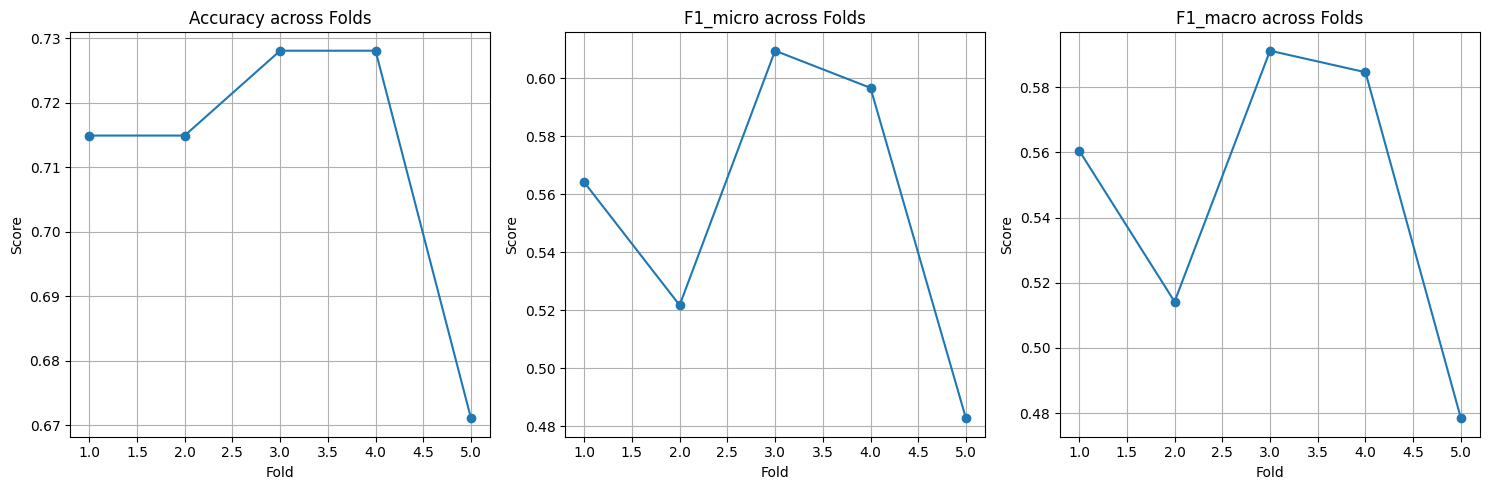


=== Training Final Model on Full Dataset ===

Saving model and preprocessing components...
Done!


In [8]:
print("=== Starting K-Fold Cross-Validation ===")
metrics, metrics_df, vectorizer, best_clf = evaluate_kfold(
    df['processed_text'], Y, strat_col, class_weights, n_splits=5
)

print("\n=== Training Final Model on Full Dataset ===")
# Vectorize full dataset
X_full = vectorizer.transform(df['processed_text'])

# Create a single base classifier for the final model
base_svc = LinearSVC(
    random_state=42,
    max_iter=2000,
    dual=False,
    C=1.0
)

# Add probability calibration
clf = CalibratedClassifierCV(base_svc, cv=3)

# Create and train final multi-output classifier
final_clf = MultiOutputClassifier(clf, n_jobs=-1)
final_clf.fit(X_full, Y)

# Save model artifacts
print("\nSaving model and preprocessing components...")
model_artifacts = {
    'classifier': final_clf,
    'vectorizer': vectorizer,
    'class_weights': class_weights
}
joblib.dump(model_artifacts, "svm_classifier_improved.joblib")
print("Done!")

## Results Analysis

In [ ]:
# Plot comprehensive results
plt.figure(figsize=(15, 12))

# Plot 1: Micro vs Macro metrics
plt.subplot(2, 1, 1)
metric_groups = ['macro', 'micro']
metrics_to_plot = ['precision', 'recall', 'f1']

x = np.arange(len(metrics_to_plot))
width = 0.35

for i, group in enumerate(metric_groups):
    metric_values = [np.mean(metrics[f'{metric}_{group}']) for metric in metrics_to_plot]
    metric_stds = [np.std(metrics[f'{metric}_{group}']) for metric in metrics_to_plot]
    
    bars = plt.bar(x + i*width, metric_values, width, yerr=metric_stds, capsize=5,
                   label=f'{group.capitalize()} Average')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.title('Model Performance Metrics')
plt.xticks(x + width/2, metrics_to_plot)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Metrics stability across folds
plt.subplot(2, 1, 2)
sns.boxplot(data=metrics_df[['accuracy', 'f1_micro', 'f1_macro']])
plt.title('Metrics Distribution Across Folds')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature importance info
print("\nFeature Information:")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
print("\nTop 20 most important features:")
feature_weights = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'idf': vectorizer.idf_
})
display(feature_weights.nlargest(20, 'idf'))